# 新段落

In [1]:
### All the computation are executed in Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/asl-alphabet.zip -d /content


流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: /content/asl-alphabet/asl_alphabet_train/asl_alphabet_train/P/P1863.jpg  
  inflating: /content/asl-alphabet/asl_alphabet_train/asl_alphabet_train/P/P99.jpg  
  inflating: /content/asl-alphabet/asl_alphabet_train/asl_alphabet_train/P/P98.jpg  
  inflating: /content/asl-alphabet/asl_alphabet_train/asl_alphabet_train/P/P1862.jpg  
  inflating: /content/asl-alphabet/asl_alphabet_train/asl_alphabet_train/P/P1876.jpg  
  inflating: /content/asl-alphabet/asl_alphabet_train/asl_alphabet_train/P/P1686.jpg  
  inflating: /content/asl-alphabet/asl_alphabet_train/asl_alphabet_train/P/P1692.jpg  
  inflating: /content/asl-alphabet/asl_alphabet_train/asl_alphabet_train/P/P2416.jpg  
  inflating: /content/asl-alphabet/asl_alphabet_train/asl_alphabet_train/P/P502.jpg  
  inflating: /content/asl-alphabet/asl_alphabet_train/asl_alphabet_train/P/P1679.jpg  
  inflating: /content/asl-alphabet/asl_alphabet_train/asl_alphabet_train/P/P264.jpg  
  inflating: /content/

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split

import tensorflow
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array, array_to_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models
from keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D,\
InputLayer,BatchNormalization,Activation
from tensorflow.keras.applications import mobilenet_v2,ResNet50V2

import cv2
import re

### Use Kera.ImageDataGenerator.flow_from_dataframe for image data processing.

In [4]:
train_folder = '/content/asl-alphabet/asl_alphabet_train/asl_alphabet_train'
index = 0
images, signdict = [], []
index = 0
for folder in sorted(os.listdir(train_folder)):
    if folder != '.DS_Store':
        for image in os.listdir(train_folder + '/' + folder):
            signdict.append({'sign':folder,'img': train_folder + '/' + folder + '/' + image})
signdf = pd.DataFrame(signdict)
signdf

,sign,img
0,A,/content/asl-alphabet/asl_alphabet_train/asl_a...
1,A,/content/asl-alphabet/asl_alphabet_train/asl_a...
2,A,/content/asl-alphabet/asl_alphabet_train/asl_a...
3,A,/content/asl-alphabet/asl_alphabet_train/asl_a...
4,A,/content/asl-alphabet/asl_alphabet_train/asl_a...
...,...,...
86995,space,/content/asl-alphabet/asl_alphabet_train/asl_a...
86996,space,/content/asl-alphabet/asl_alphabet_train/asl_a...
86997,space,/content/asl-alphabet/asl_alphabet_train/asl_a...
86998,space,/content/asl-alphabet/asl_alphabet_train/asl_a...


In [5]:
datagen=ImageDataGenerator(rescale=1./255, validation_split = 0.1)
img_width, img_height = 64, 64
train_generator=datagen.flow_from_dataframe(
    dataframe=signdf, x_col="img", y_col="sign", seed = 42,
    class_mode="categorical", color_mode = 'grayscale', target_size=(img_width, img_height), batch_size=128, subset = "training")

validation_generator = datagen.flow_from_dataframe(
    dataframe=signdf, x_col="img", y_col="sign", seed = 42,
    class_mode="categorical", color_mode = 'grayscale', target_size=(img_width, img_height), batch_size=128, subset = "validation")

Found 78300 validated image filenames belonging to 29 classes.
Found 8700 validated image filenames belonging to 29 classes.


In [6]:
## Batch normalization for standardize input
## Dropout for regularization
NN = Sequential([
    InputLayer(input_shape=(img_width, img_height, 1)),
    Conv2D(16, (3,3), 1, activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(32, (3,3), 1, activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (3,3), 1, activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    GlobalAveragePooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(29, activation='softmax')])

NN.compile(
    optimizer = Adam(lr=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [7]:
NN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 16)        160       
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 16)       64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 31, 31, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 29, 29, 32)       1

The accuracy of this preprocessing approach is not so good. The training accuracy is much higher than validation accuracy. 

In [24]:
NN_hist = NN.fit(train_generator, epochs=10, verbose=1, validation_data=validation_generator, 
       callbacks=[keras.callbacks.ModelCheckpoint('models/mnist.{epoch:02d}-{val_loss:.2f}.hdf5',
               save_best_only=True)
       ])

Epoch 1/10
612/612 [==============================] - 96s 155ms/step - loss: 2.7326 - accuracy: 0.2228 - val_loss: 6.2118 - val_accuracy: 0.0000e+00
Epoch 2/10
612/612 [==============================] - 92s 150ms/step - loss: 1.7549 - accuracy: 0.4972 - val_loss: 11.3270 - val_accuracy: 0.0018
Epoch 3/10
612/612 [==============================] - 91s 148ms/step - loss: 1.2007 - accuracy: 0.6475 - val_loss: 13.3660 - val_accuracy: 0.1232
Epoch 4/10
612/612 [==============================] - 91s 149ms/step - loss: 0.9027 - accuracy: 0.7246 - val_loss: 14.3167 - val_accuracy: 0.1728
Epoch 5/10
612/612 [==============================] - 91s 149ms/step - loss: 0.7379 - accuracy: 0.7689 - val_loss: 16.1052 - val_accuracy: 0.1928
Epoch 6/10
612/612 [==============================] - 92s 150ms/step - loss: 0.6235 - accuracy: 0.8020 - val_loss: 16.1418 - val_accuracy: 0.2262
Epoch 7/10
612/612 [==============================] - 91s 149ms/step - loss: 0.5378 - accuracy: 0.8279 - val_loss: 16.303

### Preprocessing using Opencv
The code for parsing image using Opencv is modified from https://www.kaggle.com/code/davinsthomas/cnn-adaptive-aug-template.

It can be seen that Opencv read the image in a very different way from keras. Opencv uses BGR channels while Opencv use RGB and convert image to array from PIL object.

Image Dimensions : (200, 200)


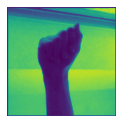

In [33]:
img_width, img_height = 64, 64
plt.figure(figsize=(2,2))
img_cv = cv2.imread('/content/asl-alphabet/asl_alphabet_train/asl_alphabet_train/A/A1.jpg',0)
plt.imshow(img_cv)
plt.axis('off')
print('Image Dimensions :', img_cv.shape)

Load the same image using keras with greyscale and compare with opencv image.

Are opencv image array the same as keras image? False


(-0.5, 199.5, 199.5, -0.5)

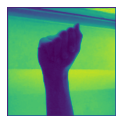

In [37]:
img_keras = tensorflow.keras.preprocessing.image.load_img(
    '/content/asl-alphabet/asl_alphabet_train/asl_alphabet_train/A/A1.jpg',
    grayscale=True
)
print('Are opencv image array the same as keras image?',np.array_equal(img_cv, img_keras))
plt.figure(figsize=(2,2))
plt.imshow(img_keras)
plt.axis('off')

The following code input opencv image array:

In [8]:
train_folder = '/content/asl-alphabet/asl_alphabet_train/asl_alphabet_train'
img_width, img_height = 64, 64
images = []
labels = []
batch_size = 512
index = 0
for folder in sorted(os.listdir(train_folder)):
    if folder != '.DS_Store':
        for image in os.listdir(train_folder + '/' + folder):
            img = cv2.imread(train_folder + '/' + folder + '/' + image,0)
            # Opencv read image in unit8 precision, it is converted to floating point variable 
            images.append(((img_to_array(cv2.resize(img, (img_width, img_height)))).astype(np.float32))/255.0)
            labels.append(index)
        index += 1

In [9]:
images = np.array(images)
labels = to_categorical(labels) 

In [10]:
x_train, x_val, y_train, y_val = train_test_split(images, labels, random_state = 42, test_size=0.1)

train_datagen = ImageDataGenerator(rescale = 1./255.0)
train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size,shuffle=False)

validation_datagen = ImageDataGenerator(rescale = 1./255.0)
validation_generator = validation_datagen.flow(x_val,y_val, batch_size=batch_size,shuffle=False)

This preprocessing approach leads to much higher accuracy, even greater validation accuracy than training accuracy, showing no overfitting. It is more reliable since the process is more transparent.

In [11]:
NN2_hist = NN.fit(x_train, y_train, epochs=10, verbose=1, validation_data=(x_val, y_val), 
       callbacks=[keras.callbacks.ModelCheckpoint(
               'models/mnist.{epoch:02d}-{val_loss:.2f}.hdf5',
               save_best_only=True)
       ])

Epoch 1/10
2447/2447 [==============================] - 20s 6ms/step - loss: 2.3060 - accuracy: 0.3438 - val_loss: 1.5588 - val_accuracy: 0.4962
Epoch 2/10
2447/2447 [==============================] - 15s 6ms/step - loss: 1.1832 - accuracy: 0.6398 - val_loss: 0.9029 - val_accuracy: 0.6794
Epoch 3/10
2447/2447 [==============================] - 15s 6ms/step - loss: 0.7870 - accuracy: 0.7513 - val_loss: 0.4832 - val_accuracy: 0.8429
Epoch 4/10
2447/2447 [==============================] - 14s 6ms/step - loss: 0.5847 - accuracy: 0.8126 - val_loss: 0.3248 - val_accuracy: 0.9009
Epoch 5/10
2447/2447 [==============================] - 15s 6ms/step - loss: 0.4531 - accuracy: 0.8536 - val_loss: 0.2353 - val_accuracy: 0.9262
Epoch 6/10
2447/2447 [==============================] - 15s 6ms/step - loss: 0.3687 - accuracy: 0.8806 - val_loss: 0.2058 - val_accuracy: 0.9369
Epoch 7/10
2447/2447 [==============================] - 15s 6ms/step - loss: 0.3116 - accuracy: 0.8983 - val_loss: 0.2067 - val_ac

In [27]:
import re
ASL_dict = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 
            10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 
            19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z', 26: 'del', 27: 'nothing', 28: 'space'}
def testdata_val(test_folder,splitname,model):
    images_te = []
    index = 0
    for img in sorted(os.listdir(test_folder)):
        images_te = []
        img2 = cv2.imread(test_folder + '/' + img, 0)
        images_te.append(((img_to_array(cv2.resize(img2, (img_width, img_height)))).astype(np.float32))/255.0)
        images_te = np.array(images_te)

        test_datagen = ImageDataGenerator(rescale = 1/255.0)
        test_generator = test_datagen.flow(images_te, None, batch_size=512,shuffle=False)

        pred = np.argmax(model.predict(images_te, verbose = 1),axis = 1)

        plt.figure(figsize=(2,2))    
        imgtitle = 'Sign: '+ re.split(splitname, img)[0] + '.\nPrediction: ' + ASL_dict[pred[0]]
        plt.title(imgtitle)
        plt.imshow(cv2.imread(test_folder + '/' + img))
        plt.axis('off')

Consistent prediction results using the original test datasets.

1/1 [==============================] - 0s 18ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1/1 [==============================] - 0s 19ms/step


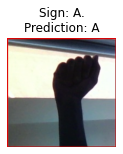

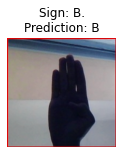

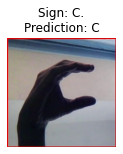

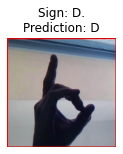

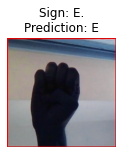

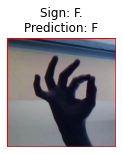

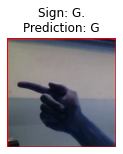

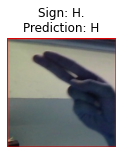

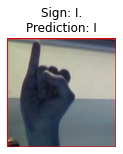

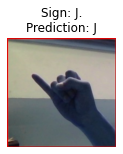

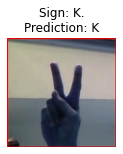

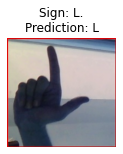

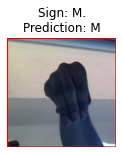

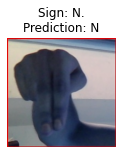

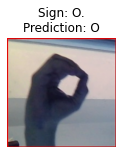

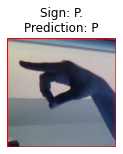

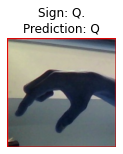

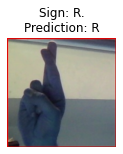

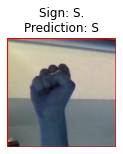

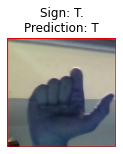

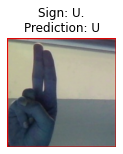

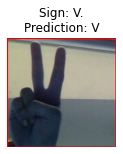

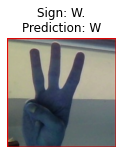

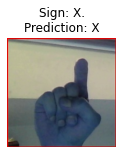

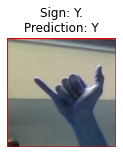

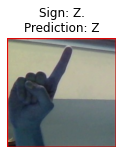

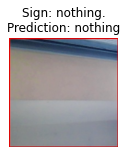

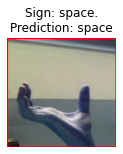

In [28]:
testdata_val('/content/asl-alphabet/asl_alphabet_test/asl_alphabet_test',"_test",NN)

But the accuracy is not good for the testing datasets custom images created by my own. The prediction accuracy is only 10/25=40%.

1/1 [==============================] - 0s 17ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1/1 [==============================] - 0s 21ms/step


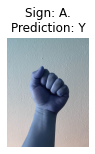

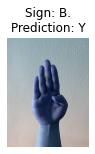

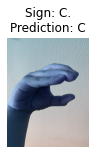

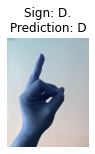

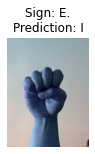

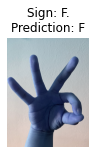

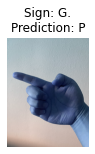

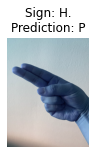

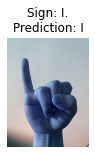

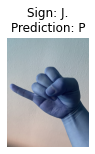

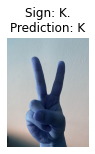

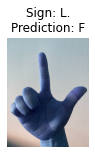

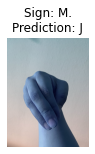

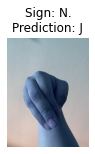

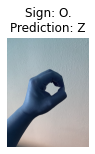

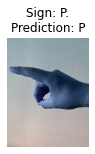

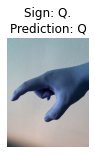

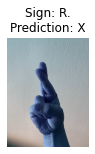

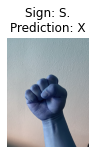

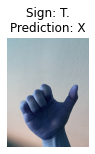

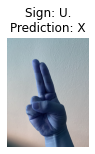

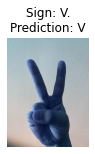

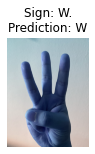

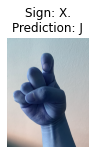

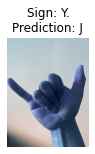

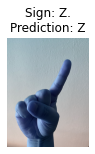

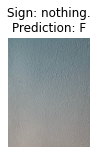

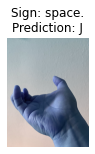

In [31]:
testdata_val('/content/asl-alphabet/myhand2',"_mh2",NN)

To detect the feature extraction process, the feature map in each convolution layer is compared between the training image and custom image.
The following code is modified from: https://www.analyticsvidhya.com/blog/2020/11/tutorial-how-to-visualize-feature-maps-directly-from-cnn-layers/

In [32]:
layer_outputs = [layer.output for layer in NN.layers]
layer_outputs

[<KerasTensor: shape=(None, 62, 62, 16) dtype=float32 (created by layer 'conv2d')>,
 <KerasTensor: shape=(None, 62, 62, 16) dtype=float32 (created by layer 'batch_normalization')>,
 <KerasTensor: shape=(None, 31, 31, 16) dtype=float32 (created by layer 'max_pooling2d')>,
 <KerasTensor: shape=(None, 31, 31, 16) dtype=float32 (created by layer 'dropout')>,
 <KerasTensor: shape=(None, 29, 29, 32) dtype=float32 (created by layer 'conv2d_1')>,
 <KerasTensor: shape=(None, 29, 29, 32) dtype=float32 (created by layer 'batch_normalization_1')>,
 <KerasTensor: shape=(None, 14, 14, 32) dtype=float32 (created by layer 'max_pooling2d_1')>,
 <KerasTensor: shape=(None, 14, 14, 32) dtype=float32 (created by layer 'dropout_1')>,
 <KerasTensor: shape=(None, 12, 12, 64) dtype=float32 (created by layer 'conv2d_2')>,
 <KerasTensor: shape=(None, 12, 12, 64) dtype=float32 (created by layer 'batch_normalization_2')>,
 <KerasTensor: shape=(None, 6, 6, 64) dtype=float32 (created by layer 'max_pooling2d_2')>,
 <

In [33]:
def feature_map_plot(imgfile):
  #Feature maps visualization Model from CNN Layers
  feature_map_model = Model(NN.input, layer_outputs)
  img = cv2.imread(imgfile,0)
  input = img_to_array(cv2.resize(img, (img_width, img_height)))
  # modified to input dimension  
  input = np.expand_dims(input, axis=0)                                          

  # Get feature map in each layer
  feature_maps = feature_map_model.predict(input)
  layer_names = [layer.name for layer in NN.layers]

  # Iterating over each layer
  for layer_name, feature_map in zip(layer_names, feature_maps):
    if len(feature_map.shape) == 4:
      k = feature_map.shape[-1]  
      size=feature_map.shape[1]
      image_belt = np.zeros([size,size*k])
      #print(k,size)
      #iterating to separate all feature images.    
      for i in range(k):
        feature_image = feature_map[0, :, :, i]
        #Standardization and Normalization of the feature image
        feature_image-= feature_image.mean()
        feature_image/= feature_image.std ()
        feature_image*=  64
        feature_image+= 128
        feature_image= np.clip(feature_image, 0, 255).astype('uint8')
        #rescale to image belt
        image_belt[:, (i * size):((i + 1) * size)] = feature_image
        scale = 20. / k
      plt.figure( figsize=(scale * k, scale) )
      plt.title ( layer_name )
      plt.grid  ( False )
      plt.imshow( image_belt, aspect='auto')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide


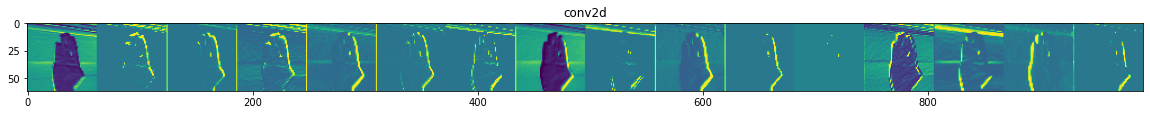

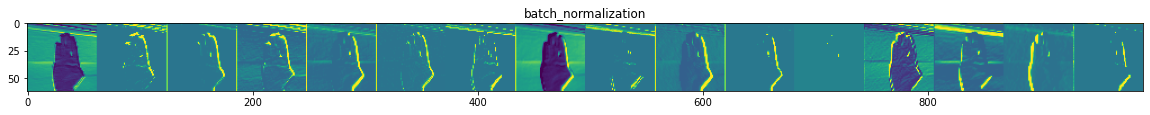

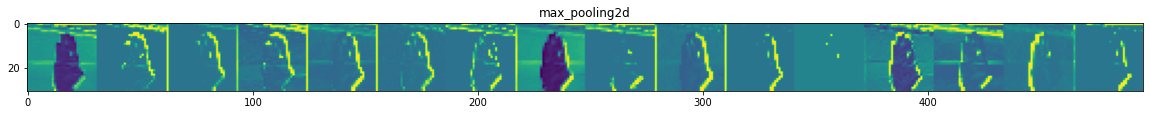

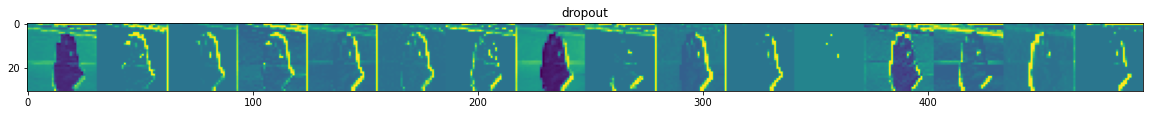

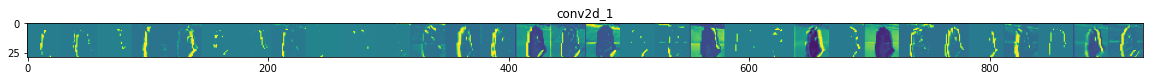

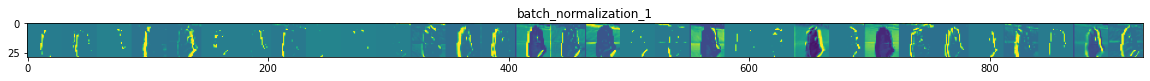

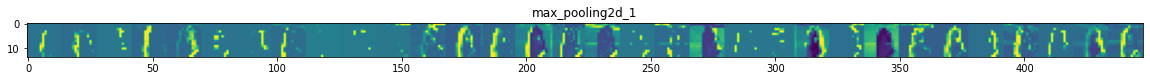

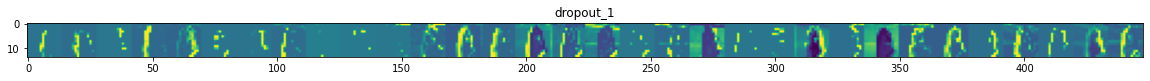

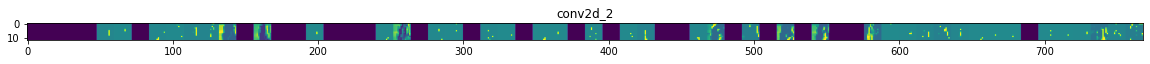

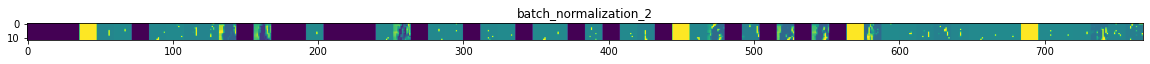

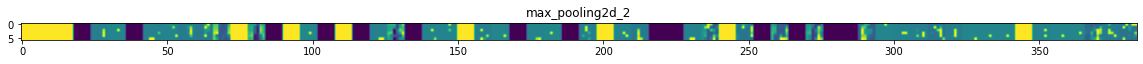

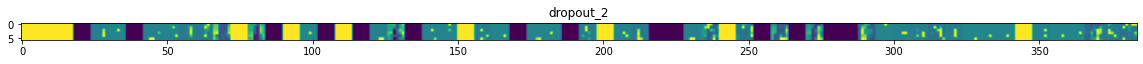

In [34]:
feature_map_plot('/content/asl-alphabet/asl_alphabet_train/asl_alphabet_train/B/B1.jpg')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide


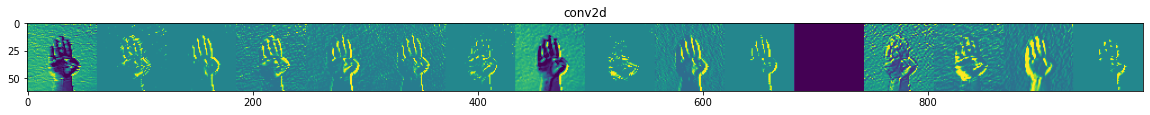

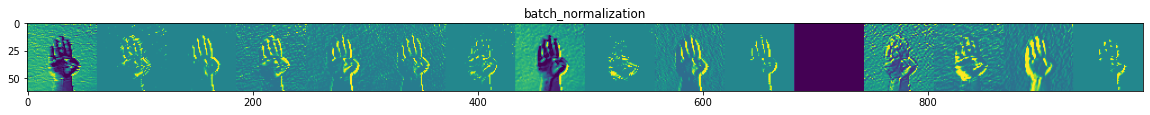

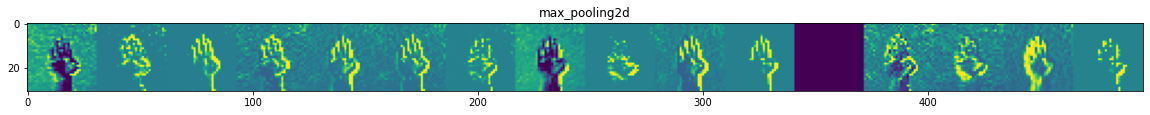

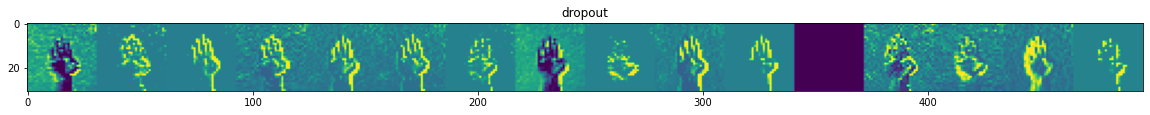

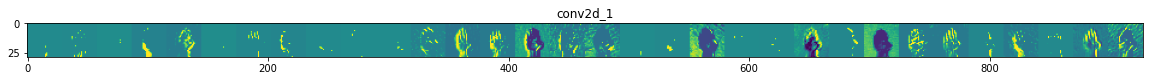

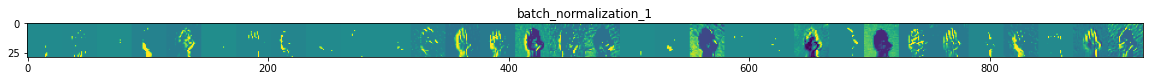

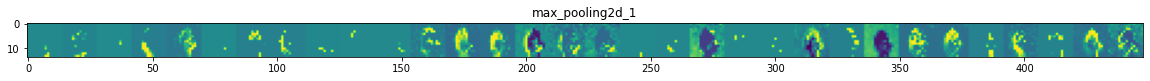

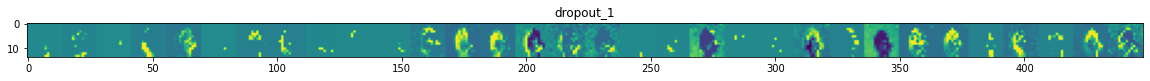

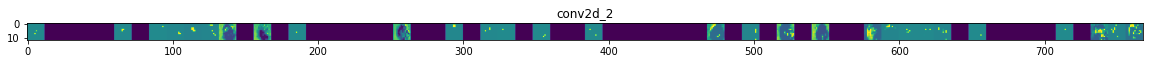

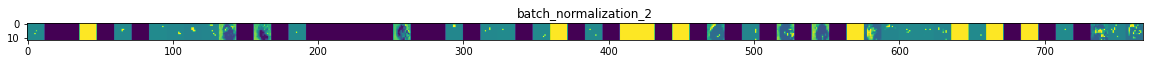

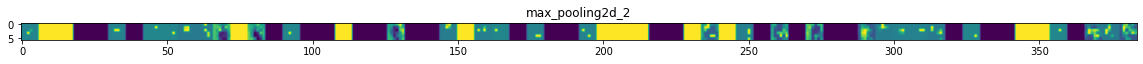

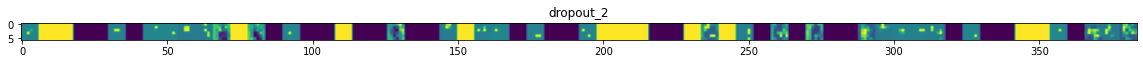

In [35]:
feature_map_plot('/content/asl-alphabet/myhand2/B_mh2.jpeg')

It is obvious that feature extraction of custom image includes the details of skins and finger, while the majority of hand contours constitute the main features for discriminating different gestures in the training images set. 

In addition, the background for the training set is really simple, numerous images with simple background texture will strengthen the CNN modeling, while custom image contains very detailed background textures, which can contaminate the main feature detection training.

Training dataset should contain more images under different environments.